In [ ]:
from google.colab import output
import tensorflow as tf
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Thesis/C_NMC_2019_dataset.zip'
output.clear()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

##Data Loader

In [ ]:
path_to_ViT_model = '/content/drive/MyDrive/Thesis/saved_models/pretrained_vit_model9502.pth'
path_to_CNN_model = '/content/drive/MyDrive/Thesis/saved_models/EfficientNet_best_model_9542.h5'

Data = os.listdir('/content/C_NMC_2019_dataset/test/hem')

## EfficientNet

In [ ]:
def preprocess_image(img, target_size=(224, 224)):
    # Resize the image
    img = cv2.resize(img, target_size)
    # Convert the image from BGR (OpenCV format) to RGB (common format)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Expand dimensions to match the shape (1, height, width, channels)
    img = np.expand_dims(img, axis=0)
    return img

def make_predictions_CNN(path_to_model, path_to_image):


  CNN_model = tf.keras.models.load_model(path_to_model)

  image = cv2.imread(path_to_image)
  image = preprocess_image(image)
  model_outputs = CNN_model.predict(image)
  predictions = model_outputs[0]


  return CNN_model, predictions

In [ ]:
# single image prediction

image_file = 'UID_H10_108_3_hem.PNG'
path_to_image = os.path.join('/content/C_NMC_2019_dataset/test/hem', image_file)


_, pred_CNN = make_predictions_CNN(path_to_CNN_model, path_to_image)
pred_CNN

1/1 [==============================] - 3s 3s/step


array([1.4834648e-05, 9.9998522e-01], dtype=float32)

## Vision Transformer

In [ ]:
def make_predictions_ViT(path_to_model, path_to_image):


  ViT_model = torch.load(path_to_model, map_location=torch.device('cpu'))
  ViT_model.to(device)
  ViT_model.eval()


  image = Image.open(path_to_image)

  transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size your model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Typical ImageNet normalization
  ])


  # image = transform(image)

  with torch.inference_mode():
      # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = transform(image).unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = ViT_model(transformed_image.to(device))

  # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  ViT_outputs = torch.softmax(target_image_pred, dim=1)
  predictions = ViT_outputs[0]

  return ViT_model, predictions

In [ ]:
image_file = 'UID_H10_108_3_hem.PNG'
path_to_image = os.path.join('/content/C_NMC_2019_dataset/test/hem', image_file)

In [ ]:
_, pred_ViT = make_predictions_ViT(path_to_ViT_model, path_to_image)
pred_ViT

tensor([0.0046, 0.9954])

In [ ]:
(pred_ViT + pred_CNN) / 2

tensor([0.0023, 0.9977])

####Ensemble Model Predictions

In [ ]:
# predict all

predictions = []

for sample in Data[1400:1600]:
  path_to_image = os.path.join('/content/C_NMC_2019_dataset/test/hem', sample)

  _, CNN_pred = make_predictions_CNN(path_to_CNN_model, path_to_image)
  _, ViT_pred = make_predictions_ViT(path_to_ViT_model, path_to_image)

  predictions.append([sample, CNN_pred, ViT_pred])

path_to_save = '/content/drive/MyDrive/Thesis/predictions.pkl/hem_1400-1600.pkl'

# Save to Pickle file
with open(path_to_save, 'wb') as pkl_file:
    pickle.dump(predictions, pkl_file)


In [ ]:
len(Data)

2360

####esnembel data

In [ ]:
ALL_pkl = []
hem_pkl = []

for pkl_name in os.listdir('/content/drive/MyDrive/Thesis/predictions.pkl'):

  if 'ALL' in pkl_name:
    ALL_pkl.append(pkl_name)

  elif 'hem' in pkl_name:
    hem_pkl.append(pkl_name)


In [ ]:
ALL_pkl

['ALL_0000-0200.pkl',
 'ALL_0200-0400.pkl',
 'ALL_0400-0600.pkl',
 'ALL_0600-0800.pkl',
 'ALL_0800-1000.pkl',
 'ALL_1000-1200.pkl',
 'ALL_1200-1400.pkl',
 'ALL_1400-1600.pkl',
 'ALL_1600-1800.pkl',
 'ALL_1800-2000.pkl',
 'ALL_2000-2200.pkl',
 'ALL_2200-2360.pkl']

In [ ]:
path_to_pickles = '/content/drive/MyDrive/Thesis/predictions.pkl'

ALL_preds = []


for pkl in ALL_pkl:

  print("Processing pkl: ", pkl)
  path_to_pickle = os.path.join(path_to_pickles, pkl)

  with open(path_to_pickle, 'rb') as file:
      data = pickle.load(file)

  for sample_preds in data:

    print("Processing file", sample_preds[0])

    sample_name = sample_preds[0]
    CNN_preds = [sample_preds[1][0], sample_preds[1][1]]
    ViT_preds = [sample_preds[2][0].item(), sample_preds[2][1].item()]
    add_to_preds = [CNN_preds, ViT_preds]
    ALL_preds.append(add_to_preds)


output.clear()

In [ ]:
path_to_pickles = '/content/drive/MyDrive/Thesis/predictions.pkl'

hem_preds = []


for pkl in hem_pkl:

  print("Processing pkl: ", pkl)
  path_to_pickle = os.path.join(path_to_pickles, pkl)

  with open(path_to_pickle, 'rb') as file:
      data = pickle.load(file)

  for sample_preds in data:

    print("Processing file", sample_preds[0])

    sample_name = sample_preds[0]
    CNN_preds = [sample_preds[1][0], sample_preds[1][1]]
    ViT_preds = [sample_preds[2][0].item(), sample_preds[2][1].item()]
    add_to_preds = [CNN_preds, ViT_preds]
    hem_preds.append(add_to_preds)


output.clear()

In [ ]:
ViT_true_positive, ViT_false_negative = 0, 0
ViT_true_negative, ViT_false_positive = 0, 0

for item in ALL_preds:

  if float(item[1][0]) > float(item[1][1]):
    ViT_true_positive += 1
  else:
    ViT_false_negative += 1

print(ViT_true_positive, ViT_false_negative)
print((ViT_true_positive/(ViT_true_positive + ViT_false_negative)))


for item in hem_preds:

  if float(item[1][0]) < float(item[1][1]):
    ViT_true_negative += 1
  else:
    ViT_false_positive += 1

print(ViT_true_negative, ViT_false_positive)
print((ViT_true_negative/(ViT_true_negative + ViT_false_positive)))

2134 226
0.9042372881355932
2231 129
0.9453389830508474


In [ ]:
ViT_true_positive, ViT_false_negative = 2134 , 226
ViT_true_negative, ViT_false_positive = 2231 , 129

arruracy, precision, recall, f1 = metrics(ViT_true_positive, ViT_false_negative, ViT_true_negative, ViT_false_positive)

print(f"ViT Model Results:")
print(f"Accuracy:  {arruracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

ViT Model Results:
Accuracy:  0.9248
Precision: 0.9430
Recall:    0.9042
F1 Score:  0.9232


ViT Model Confusion Matrix:
TP: 2134  FP: 129
FN: 226  TN: 2231


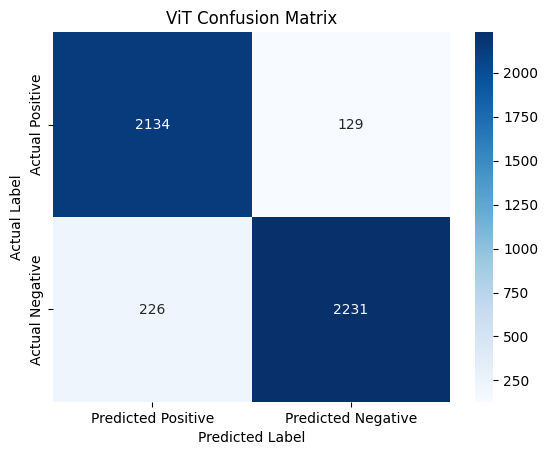

In [ ]:

# Create the confusion matrix
confusion_matrix = [[ViT_true_positive, ViT_false_positive], [ViT_false_negative, ViT_true_negative]]

# Print the confusion matrix
print("ViT Model Confusion Matrix:")
print(f"TP: {confusion_matrix[0][0]}  FP: {confusion_matrix[0][1]}")
print(f"FN: {confusion_matrix[1][0]}  TN: {confusion_matrix[1][1]}")

# Optional: Visualize using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for better visualization
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('ViT Confusion Matrix')
plt.show()


In [ ]:
CNN_true_positive, CNN_false_negative = 0, 0
CNN_false_positive, CNN_true_negative = 0, 0


for item in ALL_preds:

  if float(item[0][0]) > float(item[0][1]):
    CNN_true_positive += 1
  else:
    CNN_false_negative += 1

print(CNN_true_positive, CNN_false_negative)
print((CNN_true_positive/(CNN_true_positive + CNN_false_negative)))


for item in hem_preds:

  if float(item[0][0]) < float(item[0][1]):
    CNN_true_negative += 1
  else:
    CNN_false_positive += 1

print(CNN_true_negative, CNN_false_positive)
print((CNN_true_negative/(CNN_true_negative + CNN_false_positive)))

2243 117
0.9504237288135593
2246 114
0.9516949152542373


In [ ]:
CNN_true_positive, CNN_false_negative = 2243 , 117
CNN_true_negative, CNN_false_positive = 2246 , 114

arruracy, precision, recall, f1 = metrics(CNN_true_positive, CNN_false_negative, CNN_true_negative, CNN_false_positive)

print(f"CNN Model Results:")
print(f"Accuracy:  {arruracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

CNN Model Results:
Accuracy:  0.9511
Precision: 0.9516
Recall:    0.9504
F1 Score:  0.9510


CNN Model Confusion Matrix:
TP: 2243  FP: 114
FN: 117  TN: 2246


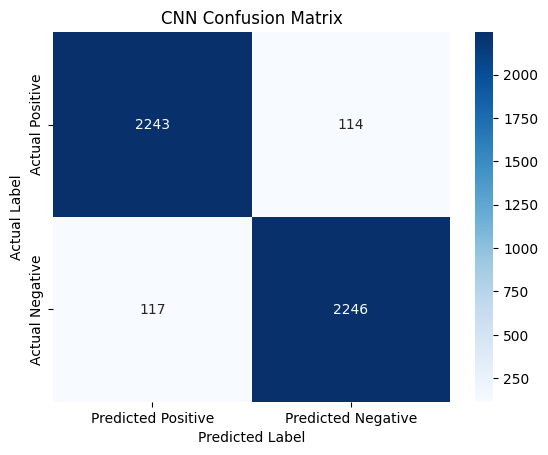

In [ ]:

# Create the confusion matrix
confusion_matrix = [[CNN_true_positive, CNN_false_positive], [CNN_false_negative, CNN_true_negative]]

# Print the confusion matrix
print("CNN Model Confusion Matrix:")
print(f"TP: {confusion_matrix[0][0]}  FP: {confusion_matrix[0][1]}")
print(f"FN: {confusion_matrix[1][0]}  TN: {confusion_matrix[1][1]}")

# Optional: Visualize using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for better visualization
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('CNN Confusion Matrix')
plt.show()


In [ ]:
CNNper100 = 0.55
ViTper100 = 0.45

ensemble_true_positive, ensemble_false_negative = 0, 0
ensemble_false_positive, ensemble_true_negative = 0, 0


for item in ALL_preds:

  if ViTper100*(item[1][0]) + CNNper100*(item[0][0]) > ViTper100*(item[1][1]) + CNNper100*(item[0][1]):
    ensemble_true_positive += 1
  else:
    ensemble_false_negative += 1

print(ensemble_true_positive, ensemble_false_negative)
print((ensemble_true_positive/(ensemble_true_positive + ensemble_false_negative)))


for item in hem_preds:

  if ViTper100*(item[1][0]) + CNNper100*(item[0][0]) < ViTper100*(item[1][1]) + CNNper100*(item[0][1]):
    ensemble_true_negative += 1
  else:
    ensemble_false_positive += 1

print(ensemble_true_negative, ensemble_false_positive)
print((ensemble_true_negative/(ensemble_true_negative + ensemble_false_positive)))

2260 100
0.9576271186440678
2259 101
0.9572033898305085


In [ ]:
ensemble_true_positive, ensemble_false_negative = 2260 , 100
ensemble_true_negative, ensemble_false_positive = 2259 , 101

arruracy, precision, recall, f1 = metrics(ensemble_true_positive, ensemble_false_negative, ensemble_true_negative, ensemble_false_positive)

print(f"ensemble Model Results:")
print(f"Accuracy:  {arruracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

ensemble Model Results:
Accuracy:  0.9574
Precision: 0.9572
Recall:    0.9576
F1 Score:  0.9574


Ensemble Model Confusion Matrix:
TP: 2260  FP: 101
FN: 100  TN: 2259


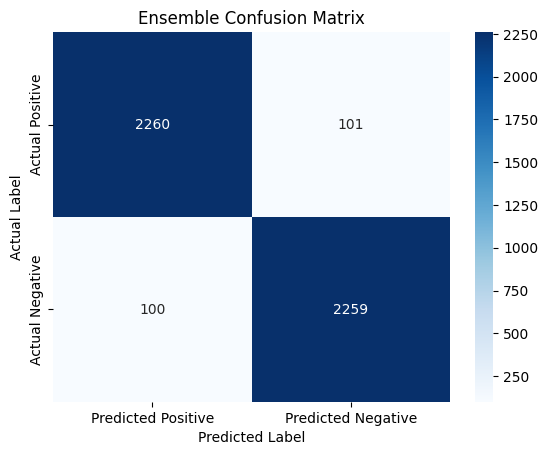

In [ ]:

# Create the confusion matrix
confusion_matrix = [[ensemble_true_positive, ensemble_false_positive], [ensemble_false_negative, ensemble_true_negative]]

# Print the confusion matrix
print("Ensemble Model Confusion Matrix:")
print(f"TP: {confusion_matrix[0][0]}  FP: {confusion_matrix[0][1]}")
print(f"FN: {confusion_matrix[1][0]}  TN: {confusion_matrix[1][1]}")

# Optional: Visualize using matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap for better visualization
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['Actual Positive', 'Actual Negative'])

plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Ensemble Confusion Matrix')
plt.show()


In [ ]:
def metrics(TP, FN, TN, FP):
  accuracy = (TP+TN)/(TP+TN+FP+FN)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1 = (2*precision*recall)/(precision+recall)

  return accuracy, precision, recall, F1

In [ ]:
ViT_true_positive, ViT_false_negative = 2134 , 226
ViT_true_negative, ViT_false_positive = 2231 , 129

arruracy, precision, recall, f1 = metrics(ViT_true_positive, ViT_false_negative, ViT_true_negative, ViT_false_positive)

print(f"ViT Model Results:")
print(f"Accuracy:  {arruracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

ViT Model Results:
Accuracy:  0.9248
Precision: 0.9430
Recall:    0.9042
F1 Score:  0.9232
